In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airpassengers/AirPassengers.csv


In [2]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import sqrt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error

# Read file and getting information

In [4]:
passenger = pd.read_csv("/kaggle/input/airpassengers/AirPassengers.csv")
passenger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
passenger.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [6]:
passenger = passenger.rename(columns = {'#Passengers':'Passengers'})

In [7]:
passenger

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [8]:
passenger= passenger.set_index("Month")
passenger.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


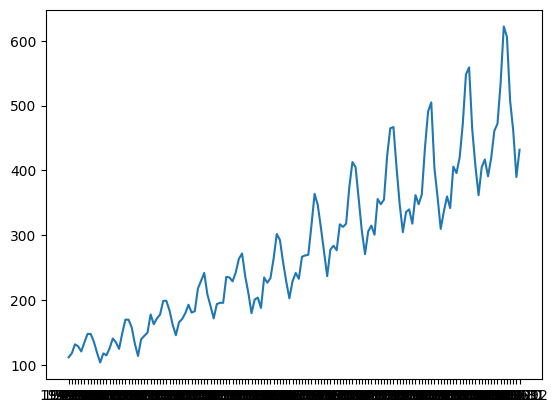

In [9]:
plt.plot(passenger)
plt.show()

In [10]:
passenger

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
...,...
1960-08,606
1960-09,508
1960-10,461


# Plot the datas

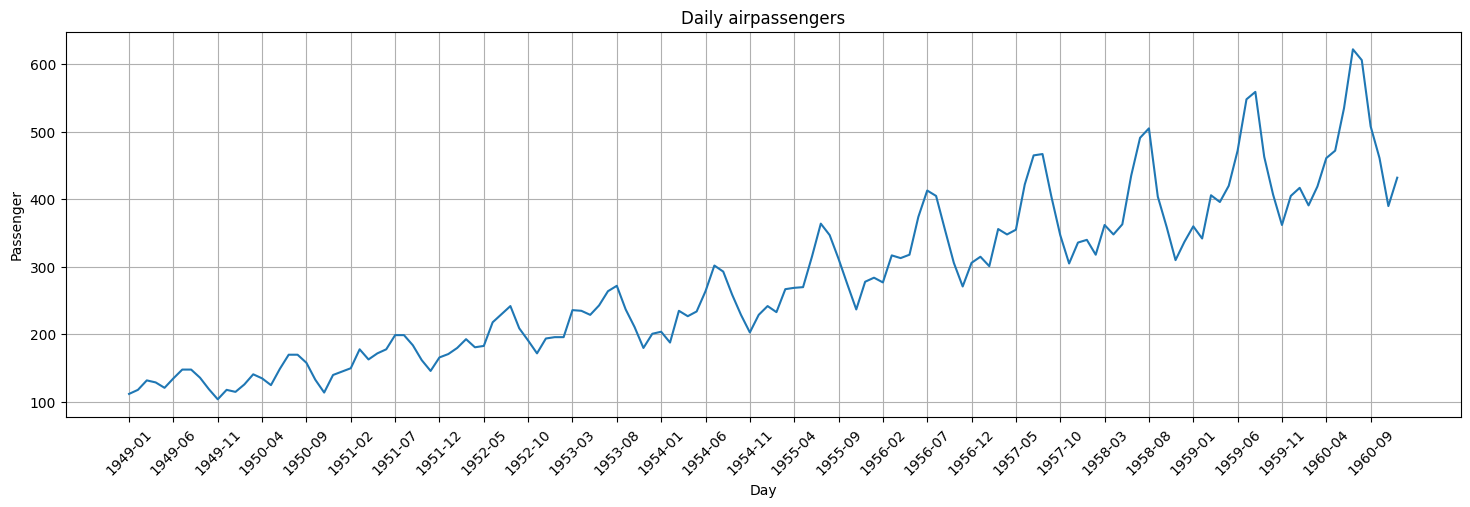

In [11]:
plt.figure(figsize = (18,5))
plt.plot(passenger["Passengers"])


plt.xlabel("Day")
plt.ylabel("Passenger")
plt.title("Daily airpassengers")

plt.xticks(passenger.index[::5], rotation=45)

plt.grid()
plt.show()

# ARIMA model prediction

In [12]:
result = adfuller(passenger["Passengers"])
print(result)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

(0.8153688792060472, 0.991880243437641, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.6929308390189)
ADF Statistic: 0.8153688792060472
p-value: 0.991880243437641


The tuple returned by the adfuller function is as follows:

(adf_statistic, p_value, used_lag, n_obs, critical_values, icbest)

if p-value < 0.05  data is stationary 

if p-value ≥ 0.05 data is not stationary

if ADF Statistic is more negative than critical values data is stationary if not data is not stationary 

Based on these values, we can say that the data is not stationary.


In [13]:
passenger_diff = passenger.diff().dropna()
passenger_diff.index = pd.to_datetime(passenger_diff.index)

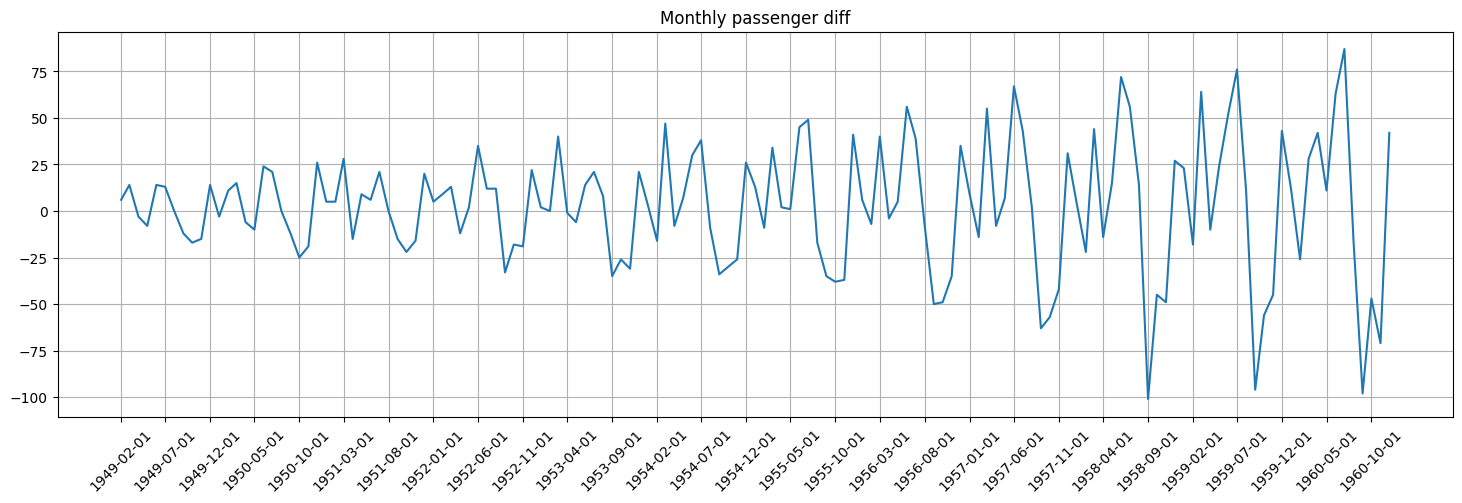

In [14]:
plt.figure(figsize=(18, 5))
plt.plot(passenger_diff.index, passenger_diff.values)
plt.xticks(passenger_diff.index[::5], rotation=45)

plt.title("Monthly passenger diff")
plt.grid()
plt.show()

data is stationary now

In [15]:
passenger_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 1949-02-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Passengers  143 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [16]:
train_pass = passenger_diff[:int(len(passenger_diff) * 0.7)]
test_pass = passenger_diff[int(len(passenger_diff) * 0.7):]

In [17]:
train = passenger[:int(len(passenger) * 0.7)]
test = passenger[int(len(passenger) * 0.7):]

splitted the data into test and train

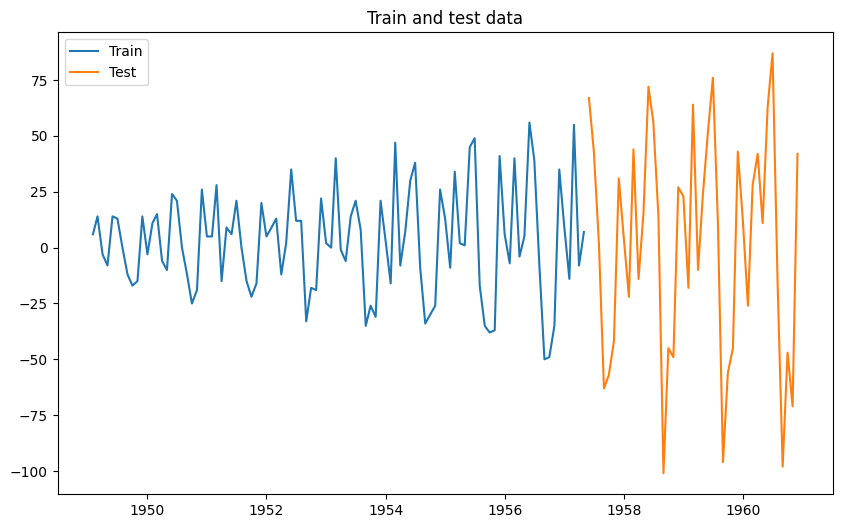

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(train_pass, label="Train")
plt.plot(test_pass, label="Test")
plt.legend()
plt.title("Train and test data")
plt.show()

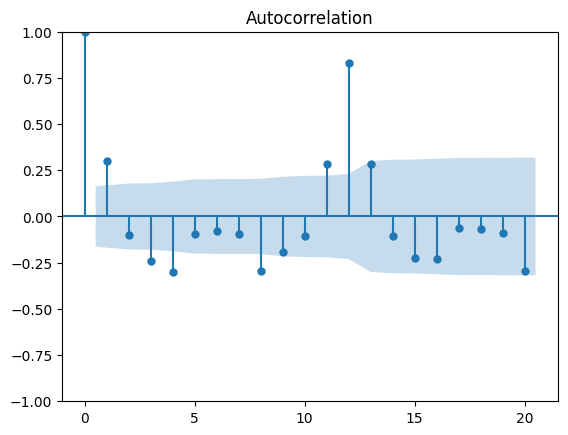

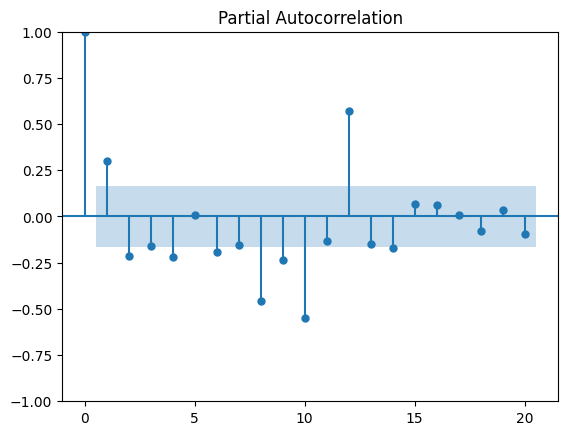

In [19]:
plot_acf(passenger_diff, lags=20)
plt.show()

plot_pacf(passenger_diff, lags=20)
plt.show()

In [20]:
model = ARIMA(train_pass, order=(2, 1, 3))  # (p, d, q) değerleri
model_fit = model.fit()

# Model özeti
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  100
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -448.399
Date:                Mon, 10 Mar 2025   AIC                            908.798
Time:                        12:14:48   BIC                            924.368
Sample:                    02-01-1949   HQIC                           915.098
                         - 05-01-1957                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0522      1.668     -0.631      0.528      -4.322       2.217
ar.L2         -0.2234      1.093     -0.204      0.838      -2.365       1.919
ma.L1          0.3878      4.659      0.083      0.9

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


1957-06-01    15.011046
1957-07-01    -4.273403
1957-08-01     6.924086
1957-09-01    -0.551125
1957-10-01     4.813600
1957-11-01     0.838232
1957-12-01     3.823046
1958-01-01     1.570216
1958-02-01     3.274067
1958-03-01     1.984383
Freq: MS, Name: predicted_mean, dtype: float64


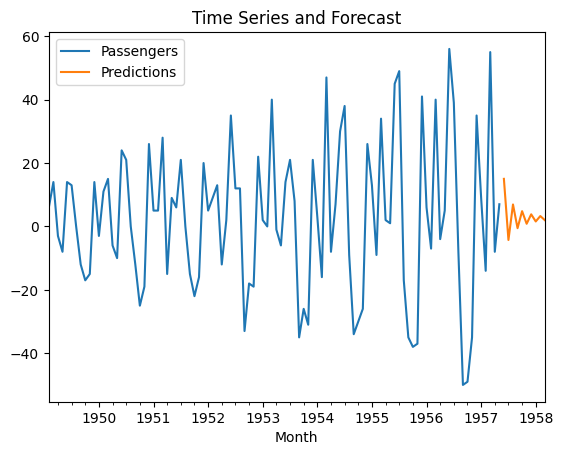

In [21]:
forecast = model_fit.forecast(steps=10)
print(forecast)


train_pass.plot(title="Time Series and Forecast")
forecast.plot(label="Predictions")
plt.legend()
plt.show()


In [22]:
from sklearn.metrics import mean_squared_error

# Örnek olarak, eğitim seti üzerinde tahmin yapalım
train_predictions = model_fit.predict(start=1, end=len(test_pass)-1)

# MSE hesaplama
mse = mean_squared_error(test_pass[1:], train_predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2469.7860337029597


In [23]:
train_pass = train_pass['Passengers']  
test_pass = test_pass['Passengers']  

In [24]:
train = train['Passengers']  
test = test['Passengers']  

making the data 1 dimensional

<ipython-input-25-a4a989f97cc5>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodel

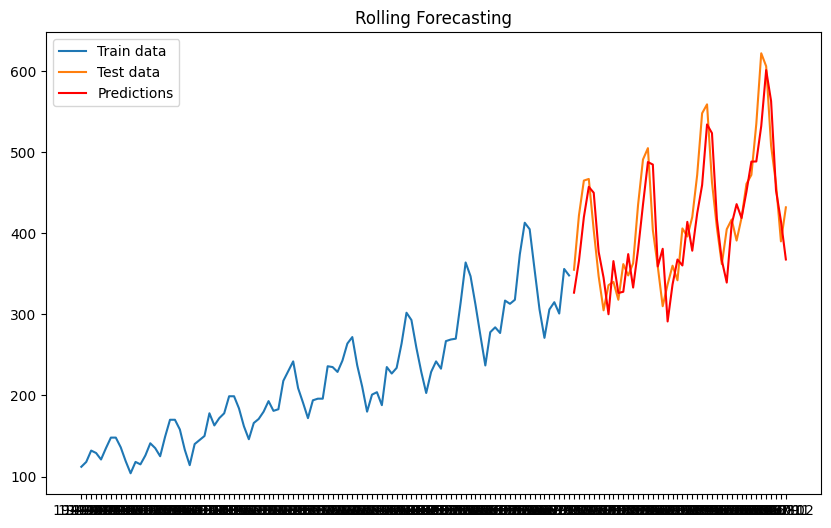

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# delete empty cells
train_pass = pd.Series(train).dropna()
test_pass = pd.Series(test).dropna()

history = [x for x in train]  
predictions = []  # keep the predictions

# Rolling forecast 
for t in range(len(test)):
    # ARIMA model
    model = ARIMA(history, order=(2, 1, 2))
    model_fit = model.fit()
    
    
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    # Add real test data to history
    obs = test[t]
    history.append(obs)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train data')
plt.plot(test, label='Test data')
plt.plot(test.index, predictions, label='Predictions', color='red')
plt.legend(loc='best')
plt.title('Rolling Forecasting')
plt.show()

In [26]:
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse:.2f}')

Test RMSE: 42.71


# Sarıma Model

In [27]:
passenger.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [28]:
auto_model = auto_arima(
    passenger,                 
    seasonal=True,             
    m=12,                      
    start_p=0, start_q=0,       
    max_p=5, max_q=5,          
    d=None,                    
    D=None,                    
    trace=True,                
    error_action='ignore',     
    suppress_warnings=True,    
    stepwise=True              
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1032.128, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.30 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.23 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.16 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.30 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.41 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.25 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.10 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.38 sec
 ARIMA(0,1,1)(1,1,1)[12]     

In [29]:
train.index = pd.to_datetime(train.index) + pd.offsets.MonthBegin(1)
test.index = pd.to_datetime(test.index) + pd.offsets.MonthBegin(1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                          Passengers   No. Observations:                  100
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -319.164
Date:                             Mon, 10 Mar 2025   AIC                            646.327
Time:                                     12:15:04   BIC                            656.191
Sample:                                 02-01-1949   HQIC                           650.299
                                      - 05-01-1957                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2576      0.100     -2.567      0.010      -0.454      -0.061
ar.S.L12      -0.2086      

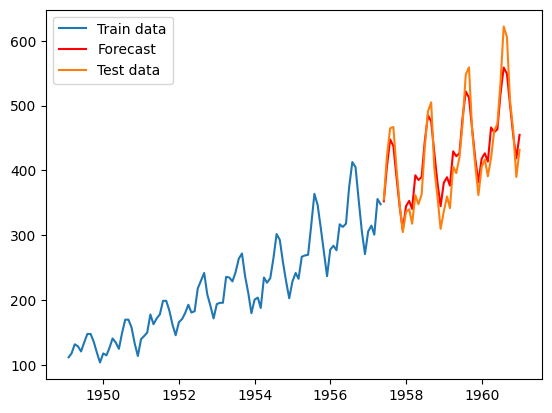

In [30]:
model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(2, 1, 0, 12))
results = model.fit()

# Model summary
print(results.summary())

# Forecasting
forecast = results.get_forecast(steps=44)
forecast_mean = forecast.predicted_mean

# Plot the forecasts
plt.plot(train, label='Train data')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.plot(test,label="Test data")

plt.legend()
plt.show()

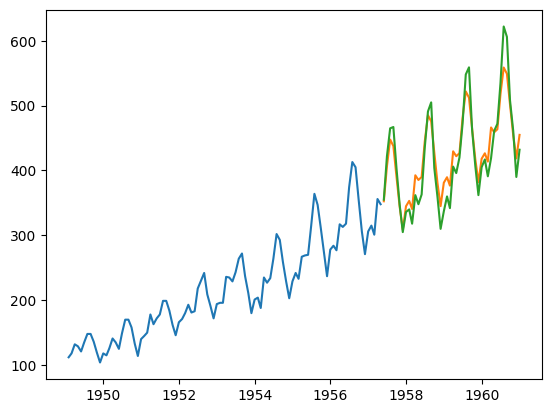

In [31]:
plt.plot(train)
plt.plot(forecast_mean)
plt.plot(test)

In [32]:
rmse = sqrt(mean_squared_error(test, forecast_mean))
print(f'Test RMSE: {rmse:.2f}')

Test RMSE: 25.88


# SARIMA Rolling Forecast Method

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-33-ff33dd03fb97>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_forecast.append(forecast_mean[0])
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: 

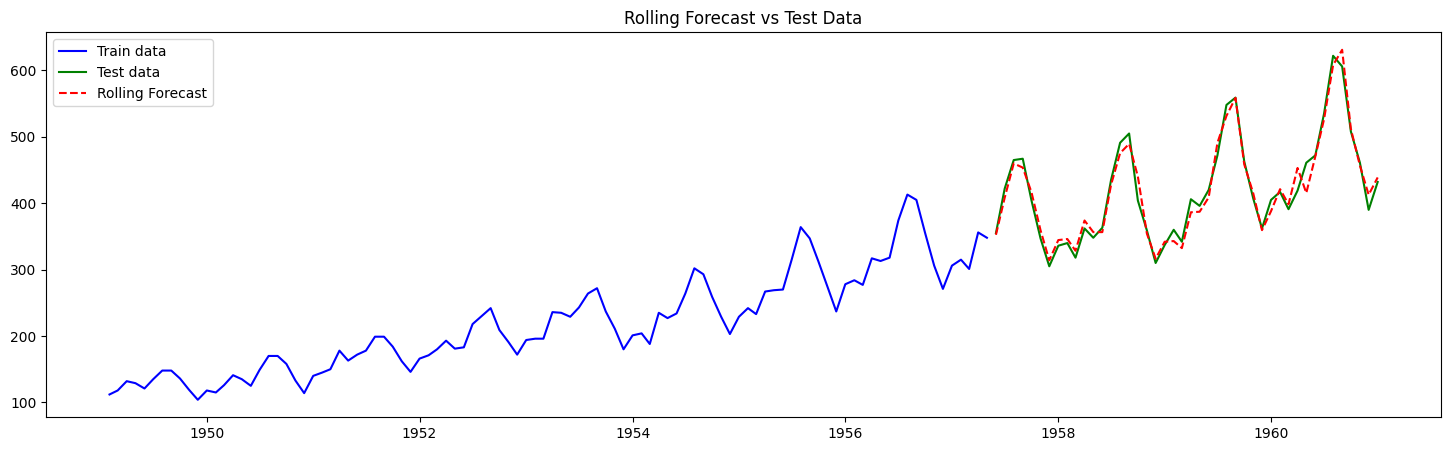

In [33]:
rolling_forecast = []
train_copy = train.copy()
test_copy = test.copy()


for i in range(len(test)):
    
    model = SARIMAX(train_copy, order=(0, 1, 1), seasonal_order=(2, 1, 0, 12))
    results = model.fit(disp=False)
    
    # Forecast 1 step
    forecast = results.get_forecast(steps=1)
    forecast_mean = forecast.predicted_mean
    
    # Add the forecast value into rolling_forecast 
    rolling_forecast.append(forecast_mean[0])
    
    # Add real test data into train_copy 
    train_copy = pd.concat([train_copy, test.iloc[[i]]])

# Plot the real data and forecasts
plt.figure(figsize = (18,5))
plt.plot(train_copy[:-len(test)], label='Train data', color='blue')
plt.plot(test.index, test, label='Test data', color='green')
plt.plot(test.index, rolling_forecast, label='Rolling Forecast', color='red', linestyle='--')

plt.legend()
plt.title('Rolling Forecast vs Test Data')
plt.show()

In [34]:
rmse = sqrt(mean_squared_error(test, rolling_forecast))
print(f'Test RMSE: {rmse:.2f}')

Test RMSE: 15.06
